**Content**: Olivier Bernard, Thomas Grenier <br>


***

Hands-on: Echocardiographic image segmentation with deep learning (part 1)
===

# <span style="color:brown"> **Preamble**

In this hands-on, you will study in depth and apply the very popular deep learning U-Net architecture to perform the segmentation of 2D echocardiographic images. This is a 30-years old problem which has taken an important step forward thanks to deep learning techniques. 
    
The material is based on a study recently published in *IEEE Transactions on Medical Imaging* (DOI: 10.1109/TMI.2019.2900516). To provide answers to the problem of echocardiographic image segmentation by deep learning methods, an open access dataset, named CAMUS, composed of 500 patients acquired in both apical two and four chamber views was set up. In this hands-on, you will use only a fraction of this dataset, i.e. the images at End-Diastole (ED) and End-Systole (ES) from 200 patients (for time efficiency). If you want to go further on this topic, don't hesitate to go on the corresponding website, you will find additional information: https://www.creatis.insa-lyon.fr/Challenge/camus/
    
# <span style="color:brown"> **Objectives**

* Consolidate the knowledge you've gained on deep learning
* Use a pre-trained model based on the classical U-Net architecture to segment echocardiographic images and assess its performance (part 1 of this hands-on),
* Train your own U-Net (part 2 of this hands-on).
    
***

# <span style="color:brown"> **CAMUS dataset**

The data for this hands-on comes from the open access CAMUS dataset. In particular, you will focus on the segmentation of three adjacent cardiac structures: the left ventricle (LV), the myocardium (MYO), and the left atrium (LA). An illustration of the reference annotation of a typical case is given below:
    
<br>
    
<img src="figures/illustration_annotations_CMR.png" alt="UNet" style="width: 70%;"/>
    
***

# <span style="color:brown"> **Segmentation network under investigation: the U-Net architecture**

U-Net is one of the most famous deep learning architectures used for image segmentation in medical imaging. It has been created by Olaf Ronneberger, Philipp Fischer and Thomas Brox in 2015 and published in the paper "UNet: Convolutional Networks for Biomedical Image Segmentation" (DOI: 10.1007/978-3-319-24574-4_28). An illustration of the network architecture is given below (please refer to Chapter 4 of the book for further explanation, in particular Figure 4.4).
    
<br>
        
<img src="figures/illustration_UNet_CMR.png" alt="UNet" style="width: 70%;"/>

This network is based on a two-stage convolutional neural network (CNN) architecture. The first part, known as the encoder, is similar to conventional CNNs and extracts high-level information. The second part is the decoder, which uses information from the encoder and applies a set of convolutions and upsampling operations to gradually transform feature maps with the purpose of reconstructing segmentation maps at the resolution of the input image. U-Net architecture also integrates skip connections between the encoder and decoder parts with the goal of retrieving details that were potentially lost during the downsampling while also stabilizing the learning procedure.
    
**Remark:** The number of filters on the last convolution layer (in red, 4 filters) is directly linked to the amount of structures to segment (4: LV, MYO, RV, and background).
    
***

# <span style="color:brown"> **Before starting: system setting**
 
### <span style="color:red"> Instruction: </span> Run the cell below to import all the packages that you will need during this session.

- [tensorflow](https://keras.io/) is a Python library for fast numerical computing created and released by Google that can be used to create deep learning models directly or by using wrapper libraries that simplify the process built on top of TensorFlow such as keras.

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [medpy](http://loli.github.io/medpy/) is a library dedicated to medical imaging in Python.
- [cv2](https://pypi.org/project/opencv-python/) is a library bindings designed to solve computer vision problems in Python.
- [os](https://docs.python.org/3/library/os.html) is a Python module that provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc...
- [sys](https://docs.python.org/3/library/sys.html) is a Python module that provides various functions and variables that are used to manipulate different parts of the Python runtime environment.

In [ ]:
# Let's download the dataset
!wget https://www.creatis.insa-lyon.fr/~bernard/jupyter/dataset.zip
!unzip -q dataset.zip
!rm dataset.zip

# and different AI models that have been already generated and stored
!wget https://www.creatis.insa-lyon.fr/~bernard/jupyter/models.zip
!unzip -q models.zip
!rm models.zip

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
!pip install medpy
!pip install tqdm

import os
import sys
import tqdm
from datetime import datetime

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,15)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


<br>
In order to make the hands-on session more fluent, we have coded our own Python modules. Some of these modules contain functions that call others tensorflow functions. So, for those who are not comfortable with python programming, we invite you to focus on running the cells in the notebook and analyzing the results generated. For the others, we invite you to regularly take a look at the functions present in our modules (loadable from the file explorer) in order to analyze how we developed the different functionalities.

### <span style="color:red"> Instruction: </span> Run the cell below to import our own modules that you will need during this session.

In [2]:
from keras_unet.utils import load_ACDC_dataset
from keras_unet.visualization import plot_overlay_segmentation, plot_compare_segmentation

# Add our own python modules stored in the folders present at the root level of this project
if "../" in sys.path: 
    print(sys.path)
else: 
    sys.path.append("../")
    print(sys.path)

if "model" in locals(): 
    print("deleting model")
    del model    
    
# Select the CPU device to run on
num_CPU = 1
num_cores = 4
tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

['/home/bernard/workspace/git/camus-hands-on', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/bernard/.local/lib/python3.9/site-packages', '/usr/local/lib64/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/usr/lib/python3.9/site-packages/IPython/extensions', '/home/bernard/.ipython', '../']


***

# <span style="color:brown"> **1) Load and prepare dataset**
    
As presented in the introduction of this hands-on session, you will use a subset of the ACDC dataset restricted to End-Diastole and End-Systole time instants from 100 patients. This dataset was divided into three folds:

- ***dataset/segmentation/train*** representing 60% of the dataset. This subset will be used to train the network by updating its parameters to get the best results on the corresponding data.
- ***dataset/segmentation/valid*** representating 20% of the dataset. This subset will be used to select the network parameters which produce the best results on the training dataset.
- ***dataset/segmentation/test*** representing 20% of the dataset. This subset will be used to assess the scores that can reach the trained network on unseen data.

## <span style="color:brown"> 1.1) Load data
    
### <span style="color:red"> Instruction: </span> Run the cell below to load the test dataset and to get more familiar with it.
    
**Remark:** The testing set contains data from 20 patients, but you'll see that it consists of 350 samples: 2D slices are considered, and the MRI stack of each subject contains several slices.

In [10]:
# Parameters
IMG_SIZE = 64  # All the images will be resized to IMG_SIZE x IMG_SIZE to speed up the process. 
               # You can play with this value and study its influence 
dataset_test_path = "dataset/segmentation/test/"

# Load data
[X_test, y_test] = load_ACDC_dataset(dataset_test_path, IMG_SIZE)


100%|██████████| 10/10 [00:00<00:00, 6582.40it/s]


### <span style="color:red"> Exercise: </span> The following lines allow you to see the size of the loaded images and reference masks stored in the `X_test` and `y_test` variables. Execute it and try to understand what each dimension corresponds to:

In [11]:
# Display the matrix size and pixel type for the return variables X_test and y_test 
print(" Dimensions of X_test : ", X_test.shape)
print(" Dimensions of y_test : ", y_test.shape)

 Dimensions of X_test :  (10, 128, 128, 1)
 Dimensions of y_test :  (10, 128, 128, 4)


<br>

**Remark**: The last dimension of `y_test` is 4. Indeed, in tensorflow implementation, it is necessary to provide one binary channel per class to segment. Since we want to segment three different structures in this project (left ventricle, myocardium and right ventricle), we set 4 channels, one for each structure plus one for the background. 


### <span style="color:red"> Exercice: </span> Execute the following code and try to better assess this notion of channel by playing with the *ind_image* parameter:

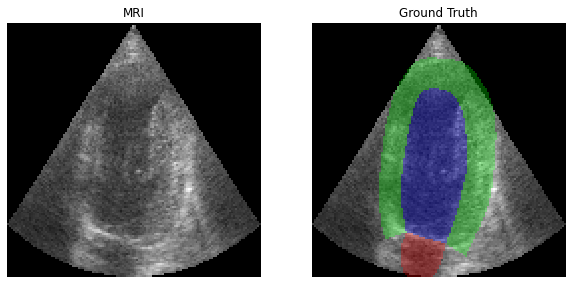

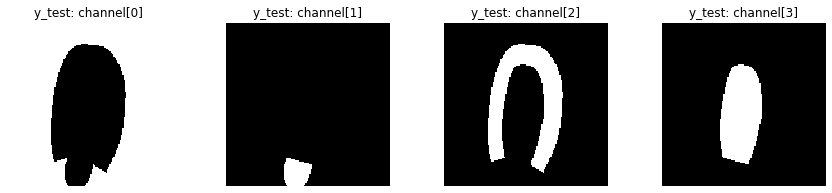

In [12]:
ind_image = 0    # indice of the selected image from the test dataset

# Display selected image along with the corresponding manual annotation in overlay
plot_overlay_segmentation(X_test[ind_image:ind_image+1], y_test[ind_image:ind_image+1])

# Display the different channel of y_test
f, axarr = plt.subplots(1, 4, figsize=(15,3))
for i in range(4):
    axarr[i].imshow(y_test[ind_image,:,:,i], 'gray', interpolation='none')
    axarr[i].set_title("y_test: channel[{}]".format(i))
    axarr[i].axis("off")

## <span style="color:brown"> 1.2) Plot images + masks + overlay (mask over original)

Let's visualize the dataset for different samples by executing the following cell. Feel free to re-run the cell multiple times to see other images. For those interested with Python programming, don't hesitate to analyze the code of the `plot_overlay_segmentation` function defined in the file `visualization.py` present in the folder named `keras_unet`.

### <span style="color:red"> Instruction: </span> Run the cell below to display the images, manual annotations and an overlay for easy viewing:

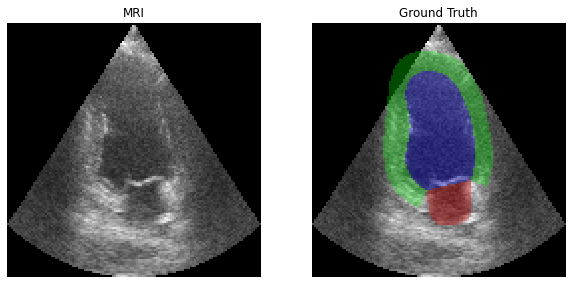

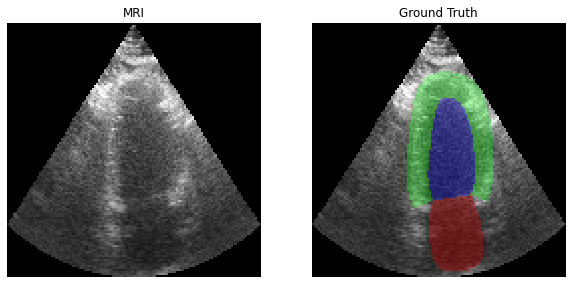

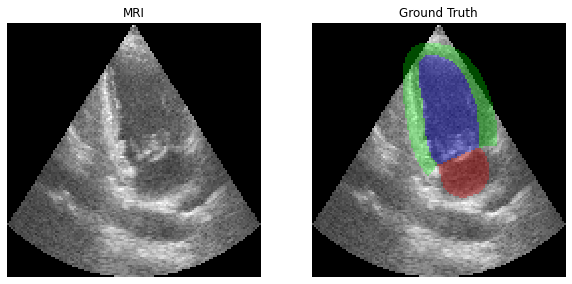

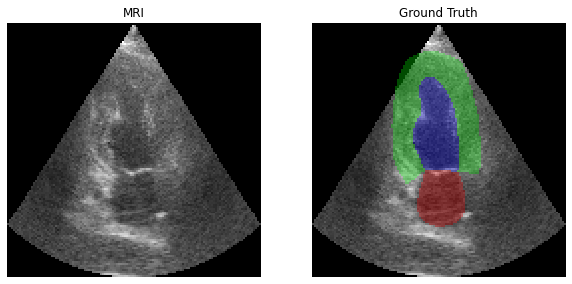

In [13]:
# Select random values
nb_imgs = 4
start_ind = (np.random.randint(0, X_test.shape[0]-nb_imgs, size=1))[0]
end_ind = start_ind+nb_imgs

# Display the random images with the corresponding reference mask
plot_overlay_segmentation(X_test[start_ind:end_ind], y_test[start_ind:end_ind])

***

# <span style="color:brown"> **2) Load the network and its weights**

We already trained a U-Net architecture to perform the segmentation of cardiac structures on cardiac MR images thanks to the ACDC dataset (you will do this task in the next hands-on session, be patient :) ). The corresponding network parameters and structure have been saved in the file `backup_model/Unet_f32_b32_l4_do0.1_Std_BN_input.h5`. In this part of the session, you will:

- Load the pre-trained U-Net model.
- Process the test dataset with this U-Net network.
- Assess the quality of the obtained results thanks to the corresponding references.

### <span style="color:red"> Instruction: </span> Run the cell below to load the pre-trained U-Net model.

In [14]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import dice_loss, dice_coef, adaptive_loss
from tensorflow.keras import models

# Filename of the pre-trained U-Net model
model_filename = "./backup_model/Unet_f32_b32_l4_do0.1_Std_BN_input.h5"

tf.keras.backend.clear_session()

# Load the network with its custom functions
loaded_model = models.load_model(model_filename, custom_objects={'dice_coef': dice_coef, 'adaptive_loss': adaptive_loss, 'dice_loss': dice_loss})

<br>

By running the next cell, you will see a summary of the U-Net architecture that was used during the training and whose best parameters were saved.

### <span style="color:red"> Instruction: </span> Run the cell below and try to analyze the corresponding architecture.


In [15]:
# display the network
loaded_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 64, 64, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### <span style="color:red"> Questions: </span>

- ### How many parameters need to be trained ?
- ### What can you say about this value in view of the difficulty of the segmentation task to be performed ?

>TODO: Your answer here.

***

# <span style="color:brown"> **3) Predict segmentations on the whole test set using the network**

## <span style="color:brown"> 3.1) Visual assessment of the quality of the predictions
    
### <span style="color:red"> Instruction: </span> Run the cell below to apply the U-Net model on the full test dataset and predict the different segmentation masks.

In [16]:
# Predict segmentations on the full test dataset
y_pred = loaded_model.predict(X_test, batch_size=1, verbose=1)

ValueError: in user code:

    /home/bernard/.local/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/bernard/.local/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/bernard/.local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/bernard/.local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/bernard/.local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/bernard/.local/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/bernard/.local/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/bernard/.local/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/bernard/.local/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer functional_1: expected shape=(None, 64, 64, 1), found shape=(1, 128, 128, 1)


### <span style="color:red"> Instruction: </span> Run the cell below to display some prediction results. Don't hesitate to re-run the cell several times to see more cases.

In [ ]:
# Select random values
nb_imgs = 3
start_ind = (np.random.randint(0, X_test.shape[0]-nb_imgs, size=1))[0]
end_ind = start_ind+nb_imgs

# Display the random images with the corresponding reference and predicted mask
plot_compare_segmentation(X_test[start_ind:end_ind], y_test[start_ind:end_ind], y_pred[start_ind:end_ind], " ", spacing=(1,1), step=1)

### <span style="color:red"> Questions: </span>

- ### How do you rate visually the quality of the predictions obtained ?
- ### Does the quality of the results vary according to the basal, mid and apex level ?
- ### If so, do you have any suggestions about the reason ?

>TODO: Your answer here.

## <span style="color:brown"> 3.2) Evaluation of the segmentation quality using standard metrics
    
In the segmentation domain, the standard metrics to assess segmentation quality are the Dice similarity index, the Hausdorff distance (HD) and the average symmetric surface distance (ASSD) whose definitions are given below:

- *Dice similarity index*: defined as $D=2\left(\left|S_{user}\cap S_{ref}\right|\right)/\left(\left|S_{user}\right|+\left|S_{ref}\right|\right)$. It is a measure of overlap between the segmented surface $S_{user}$ extracted from a method and the corresponding reference surface $S_{ref}$. The Dice index gives a value between 0 (no overlap) and 1 (full overlap).
    
- *Hausdorff distance*: measures the local maximum distance between two surfaces.
    
- *Average Symmetric Surface Distance (ASSD)*: corresponds to the average distance between two surfaces.
    
<br>

**Remark**: for simplicity, the Hausdorff distance and the average symmetric surface distance (ASSD) will be expressed in pixels - *px* - and not in *mm*.

### <span style="color:red"> Instruction: </span> Run the cells below to compute the metrics defined above on the test dataset and using the pre-trained U-Net model.

In [ ]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set
import pandas as pd
from IPython.display import display, HTML 

# Compute score on the full test dataset
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y_test, y_pred)

In [ ]:
# Put the results into a matrix and graft it into a pandas data frame (object from the panda library)
overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
overall_results_df = pd.DataFrame(data=overall_results, index = ["All", "Right Ventricle", "Myocardium", "Left Ventricle"], 
                                  columns=["Dice", "Hausdorff (px)", "ASSD (px)"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.2f' % x)))
overall_results_df.plot(kind='bar', figsize=(10,6)).legend() #bbox_to_anchor=(1.6,0.9))

# <span style="color:brown"> **You are now ready to go to part 2 of this hands-on to train your own U-Net!**